In [23]:
import pandas as pd
import os
import os.path as op
import glob
import re
import nibabel as nib
import numpy as np

from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
import gzip
import pickle

In [24]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice similarity coefficient between two binary masks.
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Parameters:
    -----------
    mask1, mask2 : array-like or nibabel image
        Binary masks (3D arrays or nibabel images)
    
    Returns:
    --------
    dice : float
        Dice coefficient (0-1, where 1 = perfect overlap)
    """
    # Convert to arrays if nibabel images
    if hasattr(mask1, 'get_fdata'):
        mask1 = mask1.get_fdata()
    if hasattr(mask2, 'get_fdata'):
        mask2 = mask2.get_fdata()
    
    # Flatten and binarize
    mask1_flat = (mask1.flatten() > 0).astype(int)
    mask2_flat = (mask2.flatten() > 0).astype(int)
    
    # Calculate intersection and sizes
    intersection = np.sum(mask1_flat * mask2_flat)
    size1 = np.sum(mask1_flat)
    size2 = np.sum(mask2_flat)
    
    # Avoid division by zero
    if size1 + size2 == 0:
        return 0.0
    
    dice = (2.0 * intersection) / (size1 + size2)
    return dice

In [25]:
def pairwise_dice_scores(roi_files, output_dir=None, force_recalc=False):
    """
    Calculate pairwise Dice coefficients between all subject-specific ROIs.
    Saves results to disk to avoid recomputation.
    
    Parameters:
    -----------
    roi_files : list
        List of file paths to subject-specific ROI NIfTI files
    output_dir : str, optional
        Directory to save/load results. If None, uses directory of first ROI file.
    force_recalc : bool, optional
        If True, recalculate even if saved files exist. Default: False
    
    Returns:
    --------
    dice_matrix : numpy.ndarray
        Symmetric matrix where dice_matrix[i,j] is the Dice coefficient 
        between ROI i and ROI j
    roi_names : list
        List of ROI filenames for indexing the matrix
    pairwise_dice_values : numpy.ndarray
        1D array of unique pairwise Dice values (excluding diagonal)
    
    Notes:
    ------
    Pickle file structure (dict):
        {
            'dice_matrix': numpy.ndarray,
            'roi_names': list,
            'pairwise_dice_values': numpy.ndarray
        }
    
    Load with: import gzip, pickle
               with gzip.open('results.pkl.gz', 'rb') as f:
                   data = pickle.load(f)
               dice_matrix = data['dice_matrix']
               roi_names = data['roi_names']
               pairwise_values = data['pairwise_dice_values']
    """
    import pickle
    import gzip
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.dirname(roi_files[0])
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output file
    results_file = os.path.join(output_dir, "pairwise_dice_results.pkl.gz")
    
    # Check if results already exist
    if not force_recalc and os.path.exists(results_file):
        print("Loading previously calculated Dice scores from disk...")
        with gzip.open(results_file, 'rb') as f:
            data = pickle.load(f)
        dice_matrix = data['dice_matrix']
        roi_names = data['roi_names']
        pairwise_dice_values = data['pairwise_dice_values']
        print(f"Loaded results for {len(roi_names)} ROIs")
        return dice_matrix, roi_names, pairwise_dice_values
    
    n_rois = len(roi_files)
    dice_matrix = np.zeros((n_rois, n_rois))
    roi_names = [os.path.basename(f) for f in roi_files]
    
    print(f"Calculating pairwise Dice scores for {n_rois} ROIs...")
    print(f"Total comparisons: {n_rois * (n_rois - 1) // 2}")
    
    # Calculate pairwise dice coefficients
    for i in range(n_rois):
        roi1 = nib.load(roi_files[i])
        for j in range(i, n_rois):  # Only upper triangle + diagonal
            if i == j:
                dice_matrix[i, j] = 1.0  # Perfect self-similarity
            else:
                roi2 = nib.load(roi_files[j])
                dice_score = dice_coefficient(roi1, roi2)
                dice_matrix[i, j] = dice_score
                dice_matrix[j, i] = dice_score  # Symmetric matrix
        
        if (i + 1) % 100 == 0:  # Progress update every 100 ROIs
            print(f"Processed {i + 1}/{n_rois} ROIs")
    
    # Extract unique pairwise values (upper triangle, excluding diagonal)
    pairwise_dice_values = dice_matrix[np.triu_indices(n_rois, k=1)]
    
    print("Pairwise Dice calculation completed!")
    print(f"\nSummary Statistics:")
    print(f"Mean Dice: {np.mean(pairwise_dice_values):.3f}")
    print(f"SD Dice: {np.std(pairwise_dice_values):.3f}")
    print(f"Median Dice: {np.median(pairwise_dice_values):.3f}")
    print(f"Range: [{np.min(pairwise_dice_values):.3f}, {np.max(pairwise_dice_values):.3f}]")
    
    # Save results to gzipped pickle file
    print(f"\nSaving results to {results_file}...")
    data = {
        'dice_matrix': dice_matrix,
        'roi_names': roi_names,
        'pairwise_dice_values': pairwise_dice_values
    }
    with gzip.open(results_file, 'wb') as f:
        pickle.dump(data, f)
    print("Results saved successfully!")
    
    return dice_matrix, roi_names, pairwise_dice_values

In [26]:
rois_dir = "./dset/seed-regions"

In [27]:
# Find all subject-specific habenula ROI files (exclude averaged/non-subject files)
subj_rois_dir = op.join(rois_dir, "subj-spec-hbs")
subj_roi_files = sorted(glob.glob(op.join(subj_rois_dir, "sub-*_roi.nii.gz")))

print(f"Found {len(subj_roi_files)} subject ROI files")
print(subj_roi_files[:5])

Found 1482 subject ROI files
['./dset/seed-regions/subj-spec-hbs/sub-0050004_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050005_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050006_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050007_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050008_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz']


In [47]:
# Calculate volume for all ROIs and print min, max, average, and median volume
voxel_volume_mm3 = 8  # 2x2x2 mm voxels
volumes = []
for roi_file in subj_roi_files:
    img = nib.load(roi_file)
    data = img.get_fdata()
    size = np.sum(data > 0)
    volume = size * voxel_volume_mm3
    volumes.append(volume)
if volumes:
    min_vol = np.min(volumes)
    max_vol = np.max(volumes)
    avg_vol = np.mean(volumes)
    median_vol = np.median(volumes)
    print(f"Min volume: {min_vol:.2f} mm³")
    print(f"Max volume: {max_vol:.2f} mm³")
    print(f"Average volume: {avg_vol:.2f} mm³")
    print(f"Median volume: {median_vol:.2f} mm³")

Min volume: 8.00 mm³
Max volume: 224.00 mm³
Average volume: 67.71 mm³
Median volume: 64.00 mm³


In [28]:
# Calculate pairwise Dice scores between all subject-specific ROIs
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")

if os.path.exists(results_path):
    print(f"Loading existing results from {results_path}...")
    with gzip.open(results_path, 'rb') as f:
        data = pickle.load(f)
    dice_matrix = data['dice_matrix']
    roi_names = data['roi_names']
    pairwise_values = data['pairwise_dice_values']
    print(f"Loaded results for {len(roi_names)} ROIs")
else:
    print("Pickle file not found. Computing pairwise Dice scores...")
    dice_matrix, roi_names, pairwise_values = pairwise_dice_scores(subj_roi_files, subj_rois_dir)
    with gzip.open(results_path, 'wb') as f:
        pickle.dump({
            'dice_matrix': dice_matrix,
            'roi_names': roi_names,
            'pairwise_dice_values': pairwise_values
        }, f)

Loading existing results from ./dset/seed-regions/subj-spec-hbs/pairwise_dice_results.pkl.gz...
Loaded results for 1484 ROIs


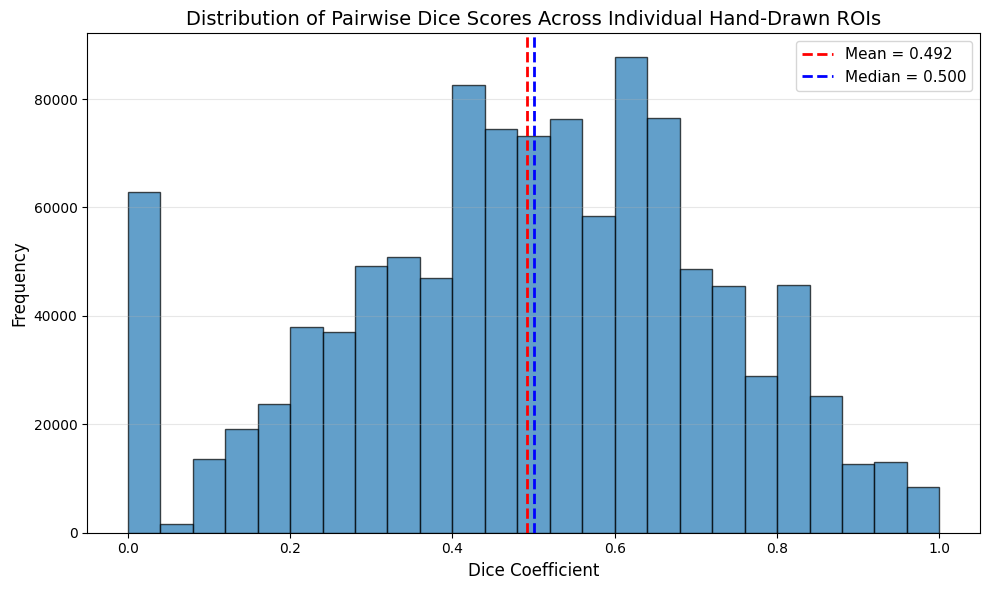

In [29]:
# Create histogram of pairwise Dice scores
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")
with gzip.open(results_path, 'rb') as f:
    data = pickle.load(f)

dice_matrix = data['dice_matrix']
roi_names = data['roi_names']
pairwise_values = data['pairwise_dice_values']

plt.figure(figsize=(10, 6))
plt.hist(pairwise_values, bins=25, edgecolor='black', alpha=0.7)
plt.xlabel('Dice Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Pairwise Dice Scores Across Individual Hand-Drawn ROIs', fontsize=14)
plt.axvline(np.mean(pairwise_values), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {np.mean(pairwise_values):.3f}')
plt.axvline(np.median(pairwise_values), color='blue', linestyle='--', linewidth=2,
            label=f'Median = {np.median(pairwise_values):.3f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Ensure all NIfTI files are loaded, binarized, and saved in AFNI-compatible format
avg_subj_roi = os.path.join(subj_rois_dir, "subj_averaged_hbroi.nii.gz")

if os.path.exists(avg_subj_roi):
    print(f"Averaged ROI already exists at {avg_subj_roi}")
else:
    afni_nii_files = []
    for i, roi_file in enumerate(subj_roi_files):
        img = nib.load(roi_file)
        data = img.get_fdata()
        # Binarize: set all nonzero voxels to 1
        bin_data = (data > 0).astype(np.uint8)
        bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
        temp_fn = os.path.join(subj_rois_dir, f"afni_bin_roi_{i}.nii.gz")
        nib.save(bin_img, temp_fn)
        afni_nii_files.append(temp_fn)

    # Use AFNI 3dMean to average all binarized ROIs
    mean_cmd = f"3dMean -prefix {avg_subj_roi} {' '.join(afni_nii_files)} > /dev/null 2>&1"
    os.system(mean_cmd)

    print(f"Averaged binarized ROI saved to: {avg_subj_roi}")
    # Clean up temporary binarized ROI files
    print("Cleaning up temporary binarized ROI files...")
    for temp_file in afni_nii_files:
        if os.path.exists(temp_file):
            os.remove(temp_file)
            print(f"Deleted: {temp_file}")
    print("Cleanup completed.")

Averaged ROI already exists at ./dset/seed-regions/subj-spec-hbs/subj_averaged_hbroi.nii.gz


In [31]:
# load the atlas based roi
atlas_roi_dir = op.join(rois_dir, "atlas-based-hb")
atlas_roi= glob.glob(op.join(atlas_roi_dir, "*dilated.nii.gz"))

print(atlas_roi)

['./dset/seed-regions/atlas-based-hb/habenula_mni_dilated.nii.gz']


In [32]:

atlas_roi_img = nib.load(atlas_roi[0])  # Take first file from the list
avg_roi_img = nib.load(avg_subj_roi)

atlas_roi_resampled = resample_to_img(atlas_roi_img, avg_roi_img, interpolation='nearest')
print(f"Atlas ROI shape: {atlas_roi_resampled.shape}")


Atlas ROI shape: (97, 115, 97, 1)


/Users/chloehampson/Desktop/habenula-comparison/.venv/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [33]:
# Calculate Dice coefficient between subject-averaged ROI and atlas ROI
atlas_vs_subj_dice = dice_coefficient(atlas_roi_resampled, avg_roi_img)

print(f"Dice coefficient between Atlas ROI and Subject-Averaged ROI: {atlas_vs_subj_dice:.4f}")

Dice coefficient between Atlas ROI and Subject-Averaged ROI: 0.6424


In [34]:
# Single iteration: randomly select increasing numbers of subj ROIs,
# average them using AFNI 3dMean (same approach as averaged ROI creation)
np.random.seed(42)

# Create binary ROIs folder
binary_rois_dir = os.path.join(subj_rois_dir, "binary_rois")
os.makedirs(binary_rois_dir, exist_ok=True)

# Create averaged ROIs folder
averaged_rois_dir = os.path.join(subj_rois_dir, "averaged_rois")
os.makedirs(averaged_rois_dir, exist_ok=True)

# Binarize all ROIs once and save to binary_rois folder
print("Binarizing all subject ROIs...")
binary_roi_files = []
for i, roi_file in enumerate(subj_roi_files):
    img = nib.load(roi_file)
    data = img.get_fdata()
    # Binarize: set all nonzero voxels to 1
    bin_data = (data > 0).astype(np.uint8)
    bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
    
    # Save with same basename but in binary_rois folder
    basename = os.path.basename(roi_file)
    bin_fn = os.path.join(binary_rois_dir, f"bin_{basename}")
    nib.save(bin_img, bin_fn)
    binary_roi_files.append(bin_fn)
    
    if (i + 1) % 100 == 0:
        print(f"Binarized {i + 1}/{len(subj_roi_files)} ROIs")

print(f"Binarized {len(binary_roi_files)}/{len(subj_roi_files)} ROIs")
print(f"All binarized ROIs saved to: {binary_rois_dir}")



Binarizing all subject ROIs...
Binarized 100/1482 ROIs
Binarized 200/1482 ROIs
Binarized 300/1482 ROIs
Binarized 400/1482 ROIs
Binarized 500/1482 ROIs
Binarized 600/1482 ROIs
Binarized 700/1482 ROIs
Binarized 800/1482 ROIs
Binarized 900/1482 ROIs
Binarized 1000/1482 ROIs
Binarized 1100/1482 ROIs
Binarized 1200/1482 ROIs
Binarized 1300/1482 ROIs
Binarized 1400/1482 ROIs
Binarized 1482/1482 ROIs
All binarized ROIs saved to: ./dset/seed-regions/subj-spec-hbs/binary_rois


In [35]:
# Load reference image to get shape and affine
ref_img = nib.load(subj_roi_files[0])

# Load and resample atlas ROI to match subject space
atlas_img = nib.load(atlas_roi[0])
print(atlas_roi[0])
atlas_resampled = resample_to_img(atlas_img, ref_img, interpolation='nearest')


./dset/seed-regions/atlas-based-hb/habenula_mni_dilated.nii.gz


/Users/chloehampson/Desktop/habenula-comparison/.venv/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Total number of binary ROIs: 1482
Sample sizes to test: [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 570, 590, 610, 630, 650, 670, 690, 710, 730, 750, 770, 790, 810, 830, 850, 870, 890, 910, 930, 950, 970, 990, 1010, 1030, 1050, 1070, 1090, 1110, 1130, 1150, 1170, 1190, 1210, 1230, 1250, 1270, 1290, 1310, 1330, 1350, 1370, 1390, 1410, 1430, 1450, 1470, 1482]


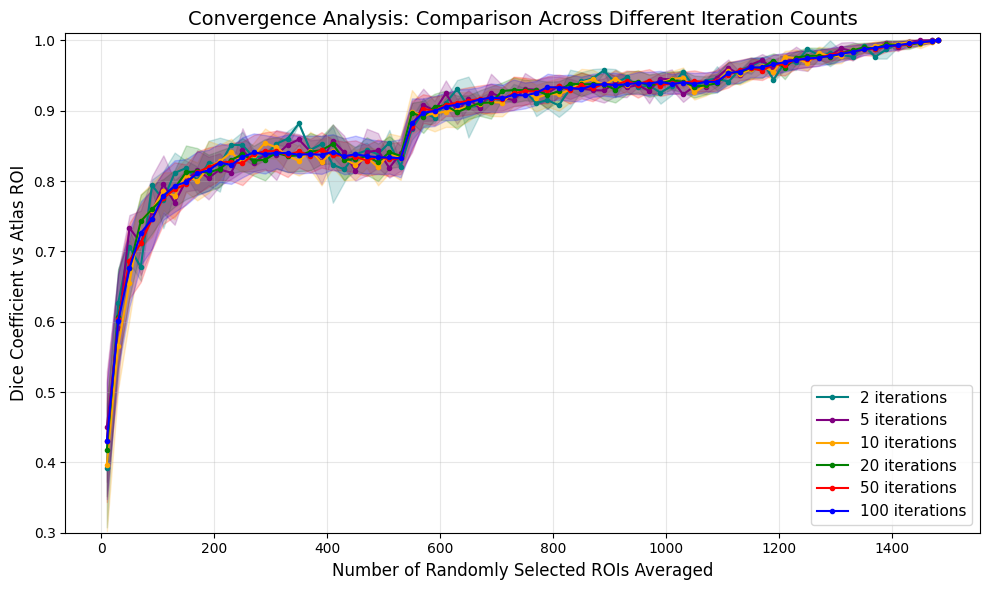

In [42]:
# Define sample sizes: 10, 20, 30, ... up to total number of subjects
n_total = len(binary_roi_files)
print(f"Total number of binary ROIs: {n_total}")

sample_sizes = list(range(10, n_total + 1, 20))
if sample_sizes[-1] != n_total:
    sample_sizes.append(n_total)

print(f"Sample sizes to test: {sample_sizes}")

# Number of iterations per sample size - can run multiple
ITERATION_COUNTS = [2, 5, 10, 20, 50, 100]  # Add or remove iteration counts as needed

# Store all results for plotting
all_iteration_results = {}

for N_ITERATIONS in ITERATION_COUNTS:
    # Check if results already exist
    results_file = os.path.join(subj_rois_dir, f"avgroi_{N_ITERATIONS}iters_results.pkl.gz")
    
    if os.path.exists(results_file):
        with gzip.open(results_file, 'rb') as f:
            all_iteration_results[N_ITERATIONS] = pickle.load(f)
    else:
        print(f"\n{'='*70}")
        print(f"RUNNING {N_ITERATIONS} ITERATIONS PER SAMPLE SIZE")
        print(f"{'='*70}")
        
        mean_dice_by_n = []
        std_dice_by_n = []
        
        for n in sample_sizes:
            print(f"\nn={n}: Running {N_ITERATIONS} iterations...")
            
            # Store Dice scores for this sample size across iterations
            dice_scores_for_n = []
            
            for iteration in range(N_ITERATIONS):
                # Different random shuffle for each iteration
                shuffled_files = np.random.permutation(binary_roi_files).tolist()
                selected_files = shuffled_files[:n]
                
                # Create a temporary file list to avoid command line length issues
                file_list_path = os.path.join(averaged_rois_dir, f"temp_avgroi_filelist_n{n}_iter{iteration}.txt")
                with open(file_list_path, 'w') as f:
                    for file_path in selected_files:
                        f.write(f"{file_path}\n")
                
                # Use AFNI 3dMean with @ syntax to read file list
                avg_roi_fn = os.path.join(averaged_rois_dir, f"avgroi_n{n}_iter{iteration}.nii.gz")
                mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}` > /dev/null 2>&1"
                result = os.system(mean_cmd)
                
                # Clean up temp file list
                os.remove(file_list_path)
                
                if result != 0:
                    print(f"WARNING: 3dMean failed for n={n}, iteration {iteration}")
                    dice_scores_for_n.append(np.nan)
                    continue
                
                # Load averaged ROI and calculate Dice against atlas
                avg_img = nib.load(avg_roi_fn)
                dice_score = dice_coefficient(avg_img, avg_roi_img)
                dice_scores_for_n.append(dice_score)
                
                # Optional: delete the averaged ROI to save space
                os.remove(avg_roi_fn)
            
            # Calculate mean and SD for this sample size
            mean_dice = np.nanmean(dice_scores_for_n)
            std_dice = np.nanstd(dice_scores_for_n)
            
            mean_dice_by_n.append(mean_dice)
            std_dice_by_n.append(std_dice)
            
            print(f"  n={n}: {mean_dice:.4f} ± {std_dice:.4f}")
        
        # Store results
        all_iteration_results[N_ITERATIONS] = {
            'mean': np.array(mean_dice_by_n),
            'std': np.array(std_dice_by_n),
            'sample_sizes': sample_sizes,
            'n_iterations': N_ITERATIONS
        }
        
        # Save results
        print(f"\nSaving results to {results_file}...")
        with gzip.open(results_file, 'wb') as f:
            pickle.dump(all_iteration_results[N_ITERATIONS], f)
        print(f"Results saved successfully!")
        print(f"\nMean Dice scores across {N_ITERATIONS} iterations per sample size:")
        for i, n in enumerate(sample_sizes):
            if n % 100 == 0 or n == sample_sizes[-1]:
                print(f"n={n}: {all_iteration_results[N_ITERATIONS]['mean'][i]:.4f} ± {all_iteration_results[N_ITERATIONS]['std'][i]:.4f}")

# Plot convergence curves for all iteration counts
plt.figure(figsize=(10, 6))
colors = ['teal', 'purple', 'orange', 'green', 'red', 'blue']

for idx, N_ITERATIONS in enumerate(ITERATION_COUNTS):
    if N_ITERATIONS in all_iteration_results:
        all_results = all_iteration_results[N_ITERATIONS]
        color = colors[idx % len(colors)]
        result_sample_sizes = all_results['sample_sizes']
        
        plt.plot(result_sample_sizes, all_results['mean'], 'o-', color=color, 
                markersize=3, linewidth=1.5, label=f'{N_ITERATIONS} iterations')
        plt.fill_between(result_sample_sizes, 
                         all_results['mean'] - all_results['std'], 
                         all_results['mean'] + all_results['std'], 
                         color=color, alpha=0.2)

plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
plt.title(f'Convergence Analysis: Comparison Across Different Iteration Counts', fontsize=14)
plt.ylim(top=1.01, bottom=0.3)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
for idx, N_ITERATIONS in enumerate(ITERATION_COUNTS):
    if N_ITERATIONS in all_iteration_results:
        all_results = all_iteration_results[N_ITERATIONS]
        x = np.array(all_results['sample_sizes'])
        y = np.array(all_results['mean'])
        # Focus on x between 400 and 600
        mask = (x >= 400) & (x <= 600)
        x_sub = x[mask]
        y_sub = y[mask]
        # Compute slope between consecutive points
        slopes = np.diff(y_sub) / np.diff(x_sub)
        # Find the index of the maximum slope (steepest increase)
        max_slope_idx = np.argmax(slopes)
        # Optionally, find where the slope returns to a lower value after the max
        # Here, we just take the next minimum after the max
        min_slope_idx = max_slope_idx + 1 + np.argmin(slopes[max_slope_idx+1:]) if (max_slope_idx+1 < len(slopes)) else max_slope_idx
        print(f'For {N_ITERATIONS} iterations:')
        print(f'  Steep increase starts at x={x_sub[max_slope_idx]}, y={y_sub[max_slope_idx]:.4f}')
        print(f'  Steep increase ends at x={x_sub[min_slope_idx]}, y={y_sub[min_slope_idx]:.4f}')

For 2 iterations:
  Steep increase starts at x=530, y=0.8207
  Steep increase ends at x=570, y=0.8979
For 5 iterations:
  Steep increase starts at x=530, y=0.8392
  Steep increase ends at x=570, y=0.9084
For 10 iterations:
  Steep increase starts at x=530, y=0.8328
  Steep increase ends at x=550, y=0.8984
For 20 iterations:
  Steep increase starts at x=530, y=0.8358
  Steep increase ends at x=550, y=0.8968
For 50 iterations:
  Steep increase starts at x=530, y=0.8326
  Steep increase ends at x=570, y=0.9029
For 100 iterations:
  Steep increase starts at x=530, y=0.8324
  Steep increase ends at x=570, y=0.8970
